# 导入数据

In [3]:
import pandas as pd
import numpy as np

In [4]:
data_train=pd.read_csv(r'../input/u-churn-prediction/u-churn-train-clean.csv')
data_test=pd.read_csv(r'../input/u-churn-prediction/u-churn-test-clean.csv')
data_train.shape,data_test.shape

((5634, 18), (1409, 17))

In [5]:
data_train

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0.291667,0,0,2,0,2,0,0,2,1,0,3,0.480649,0.519787,0
1,0,0,0,0.750000,2,1,0,2,0,0,2,2,2,1,0,0.795304,0.840938,0
2,0,1,0,0.013889,1,0,0,0,0,0,0,0,0,1,2,0.056440,0.015305,1
3,0,0,0,0.055556,0,1,0,0,0,0,0,0,0,1,2,0.533431,0.240466,1
4,0,0,1,0.000000,2,0,2,2,0,2,0,0,2,1,0,0.451395,0.634603,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,1,0,0.013889,0,1,2,0,0,0,2,2,0,1,2,0.774212,0.135086,1
5630,0,1,1,0.319444,2,0,2,2,2,2,2,2,2,1,1,0.736723,0.625939,0
5631,0,1,1,0.166667,0,2,1,1,1,1,1,1,0,1,2,0.031617,0.273939,0
5632,1,0,0,0.166667,2,1,0,0,2,0,2,2,0,1,2,0.816836,0.498500,1


# 定义模型

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):  # num_classes 默认为 2（二分类）
        super(MLPClassifier, self).__init__()
        # 将input_dim/2转换为整数
        hidden_dim = int(input_dim * 2)
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # 加入 BatchNorm
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # 加入 BatchNorm
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes),  # 输出层
        )

        self.apply(self.init_weights)  # 应用权重初始化

    def forward(self, x):
        # 直接返回logits，不应用激活函数
        # CrossEntropyLoss会在内部应用Softmax
        return self.model(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")  # He 初始化
            if m.bias is not None:
                m.bias.data.zero_()

In [9]:
def evaluate_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        # 多分类任务：取最大概率的类别作为预测结果
        preds = torch.argmax(outputs, dim=1)
        accuracy = accuracy_score(y_test.cpu().numpy(), preds.cpu().numpy())
    return accuracy

In [10]:
# 训练模型（带早停策略）
def train_model(X, y, k_folds=5, epochs=1000, lr=0.001, batch_size=64, patience=50):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_losses = {"train": [], "val": []}
    best_scores = []  # 记录每折的最佳验证损失
    best_models = []  # 保存每折的最佳模型

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nFold {fold+1}/{k_folds}")

        # 数据划分
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        # 转换 Tensor
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        # 多分类任务，目标变量应为整数张量
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

        # DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # 初始化模型
        model = MLPClassifier(X_train.shape[1]).to(device)

        # 多分类任务使用CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(
            model.parameters(), lr=lr, weight_decay=1e-4
        )  # weight_decay=1e-4 可防止权重过大导致过拟合
        scheduler = ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=10, verbose=True
        )

        # 记录损失
        fold_train_loss = []
        fold_val_loss = []
        best_val_loss = float("inf")
        patience_counter = 0  # 早停计数器
        best_model_state = None  # 保存最佳模型的状态字典

        # 训练循环
        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0.0

            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * batch_X.size(0)

            # 计算平均损失
            epoch_train_loss /= len(train_loader.dataset)
            fold_train_loss.append(epoch_train_loss)

            # 验证
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
                fold_val_loss.append(val_loss)

            # 学习率调整
            scheduler.step(val_loss)

            # 早停逻辑
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # 重新计数
                best_model_state = model.state_dict()  # 保存最佳模型状态
            else:
                patience_counter += 1

            # 打印日志
            if (epoch + 1) % 20 == 0:
                val_accuracy = evaluate_accuracy(model, X_val_tensor, y_val_tensor)
                print(
                    f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}"
                )

            # 触发早停
            if patience_counter >= patience:
                print(
                    f"Early stopping at epoch {epoch+1} | Best Val Loss: {best_val_loss:.4f}"
                )
                break

        # 加载最佳模型
        best_model = MLPClassifier(X_train.shape[1]).to(device)
        best_model.load_state_dict(best_model_state)
        best_models.append(best_model)  # 保存最佳模型

        # 记录当前 fold 的损失
        fold_losses["train"].append(fold_train_loss)
        fold_losses["val"].append(fold_val_loss)
        best_scores.append(best_val_loss)  # 记录最佳验证损失

    # 计算所有折的平均最佳验证损失
    final_score = np.mean(best_scores)
    print(f"\nFinal Model Score (Avg Best Val Loss): {final_score:.4f}")

    # 返回所有折的最佳模型和平均最佳验证损失
    return best_models, fold_losses, final_score


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train.iloc[:,:-1], data_train.iloc[:,-1], test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4507, 17), (1127, 17), (4507,), (1127,))


Fold 1/5
Epoch 20/1000 | Train Loss: 0.4321 | Val Loss: 0.4570 | Val Accuracy: 0.7805
Epoch 40/1000 | Train Loss: 0.4151 | Val Loss: 0.4498 | Val Accuracy: 0.7816
Epoch 60/1000 | Train Loss: 0.4082 | Val Loss: 0.4481 | Val Accuracy: 0.7805
Epoch 00062: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00073: reducing learning rate of group 0 to 2.5000e-04.
Epoch 80/1000 | Train Loss: 0.4029 | Val Loss: 0.4507 | Val Accuracy: 0.7905
Epoch 00084: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00095: reducing learning rate of group 0 to 6.2500e-05.
Epoch 100/1000 | Train Loss: 0.4042 | Val Loss: 0.4506 | Val Accuracy: 0.7894
Epoch 00106: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00117: reducing learning rate of group 0 to 1.5625e-05.
Epoch 120/1000 | Train Loss: 0.4062 | Val Loss: 0.4508 | Val Accuracy: 0.7927
Epoch 00128: reducing learning rate of group 0 to 7.8125e-06.
Epoch 00139: reducing learning rate of group 0 to 3.9063e-06.
Epoch 140/1000 | Train Loss: 0

IndexError: list index out of range

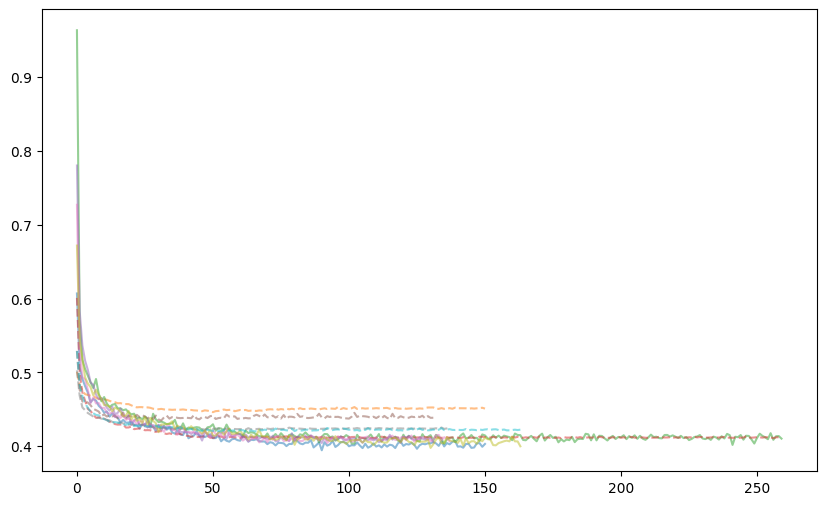

In [13]:
# 训练模型并获取损失记录和最终 Score
k_folds=5
best_models,fold_losses, final_score = train_model(X_train.values.astype(float), y_train.values.astype(float), 
                                       k_folds=k_folds, epochs=1000, lr=0.001, batch_size=64, patience=100)

# 可视化
plt.figure(figsize=(10, 6))
for fold in range(k_folds):
    plt.plot(fold_losses['train'][fold], label=f'Fold {fold+1} Train', alpha=0.5)
    plt.plot(fold_losses['val'][fold], label=f'Fold {fold+1} Val', linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Fold')
plt.legend()
plt.show()

In [14]:
# 使用最佳模型进行预测
best_model = best_models[-1]  # 选择最后一个折的最佳模型

# 将DataFrame转换为NumPy数组，再转换为Tensor
X_valid_tensor = torch.tensor(X_valid.values.astype(float), dtype=torch.float32).to(device)

# 对于多分类模型，目标变量应该是整数类型，不需要view(-1, 1)
y_valid_tensor = torch.tensor(y_valid.values.astype(int), dtype=torch.long).to(device)

# 评估模型
test_accuracy = evaluate_accuracy(best_model, X_valid_tensor, y_valid_tensor)
print(f"验证集上最佳模型的准确率: {test_accuracy:.4f}")

验证集上最佳模型的准确率: 0.7924


# submit

In [15]:
best_model.eval()
with torch.no_grad():
    output = best_model(torch.tensor(data_test.values.astype(float), dtype=torch.float32).to(device))
    y_pred = torch.argmax(output, dim=1).cpu().numpy()
y_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [16]:
y_pred=pd.Series(y_pred.squeeze()).map({1: 'Yes', 0: 'No'})
y_pred

0       Yes
1        No
2        No
3       Yes
4        No
       ... 
1404     No
1405     No
1406     No
1407     No
1408    Yes
Length: 1409, dtype: object

In [18]:
sample_submission_df = pd.read_csv('../input/u-churn-prediction/u-churn-submission-sample.csv')
sample_submission_df['Churn'] = y_pred
sample_submission_df.to_csv('../working/submission.csv', index=False)
sample_submission_df.head()

,customerID,Churn
0,1024-GUALD,Yes
1,0484-JPBRU,No
2,3620-EHIMZ,No
3,6910-HADCM,Yes
4,8587-XYZSF,No
